# Feature Reduction with best prediction accuracy 

The goal of the project was it to predict which player is playing a certain game based on the moves he or she made.

## Pre-processing Training Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

## Pre-processing Training Data
As shown and explained on the other [**notebook**](StarCraft_Player_Prediction.ipynb), we pre-process data in order to fully exploit in the best way possible all the data.

In [2]:
# Load the training dataset
train_data = pd.read_csv('train_data.csv', delimiter=';')

# Drop unnecessary columns
train_data = train_data.drop(['PlayerURL', 'PlayerName'], axis=1)

In [3]:
def count_moves(row, counts, index):
    total_moves = 0
    for i in range(1, 2564):
        move = row["Move "+ str(i)]
        # count the number of s's
        if move == 's':
            counts[10][index] += 1
        # count the number of Base's
        elif move == 'Base':
            counts[11][index] += 1
        # count the number of SingleMineral's
        elif move == 'SingleMineral':
            counts[12][index] += 1
        # count the hotkeys
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[j][index] += 1

        total_moves += 1  
    # Save the total moves count
    counts[13][index] = total_moves


def count_move_per_time(row, counts, row_index, time_interval, ti_index):
    base_index = ti_index * 14
    total_moves = 0

    for i in range(1, 2564):
        move = row["Move " + str(i)]

        # Count actions for the given time interval
        if move == 's':
            counts[base_index + 10][row_index] += 1
        elif move == 'Base':
            counts[base_index + 11][row_index] += 1
        elif move == 'SingleMineral':
            counts[base_index + 12][row_index] += 1
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[base_index + j][row_index] += 1

        total_moves += 1

        # Continue counting actions after the specified time interval
        if move == f't{time_interval}':
            break

    counts[base_index + 13][row_index] = total_moves


def mapRaces(races, row_index):
    race = train_data['Race'][row_index]

    if race == "Protoss":
        races[0][row_index] = 1
    elif race == "Terran":
        races[1][row_index] = 1
    elif race == "Zerg":
        races[2][row_index] = 1

In [4]:
# Create new table that only contains the first column (PlayerId) of train_data
# Keep only the first column but all rows
train_data_new = train_data.iloc[:, :1]


# Specify the target time intervals
#time_intervals = [20, 60, 100, 200]
time_intervals = [5, 20, 60, 100, 200, 270, 340, 550]

calc_column = len(time_intervals)* 14 + 14

# New lists of counts
counts = [[0] * 3052 for _ in range(calc_column)]
# New lists of races
races = [[0] * 3052 for _ in range(3)]


# Go through the rows using the functions to count the actions, map the races
for row_index, row in train_data.iterrows():
    count_moves(row, counts, row_index)
    mapRaces(races, row_index)

    for ti_index, time_interval in enumerate(time_intervals):
        count_move_per_time(row, counts, row_index, time_interval, ti_index+1)
        

for i in range(calc_column):
    locals()[f'count_{i}'] = counts[i]

for i in range(10):
    train_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]

train_data_new['sFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[10])]
train_data_new['baseFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[11])]
train_data_new['singleMineralFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[12])]

# Adding new columns for the count of moves per interval
for ti_index, time_interval in enumerate(time_intervals):
    base_index = (ti_index + 1) * 14
    for j in range(10):
        column_name = f'hk{j}_t{time_interval}_Frequency'
        train_data_new[column_name] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + j])]

    train_data_new[f's_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 10])]
    train_data_new[f'base_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 11])]
    train_data_new[f'singleMineral_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 12])]



# Adding new columns for the races
train_data_new['race_Protoss'] = races[0]
train_data_new['race_Terran'] = races[1]
train_data_new['race_Zerg'] = races[2]


In [5]:
# Target
labels = train_data_new['PlayerID']

# Keep only the columns we need as features
features = train_data_new.drop(['PlayerID'], axis=1)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)


Right now, we try to find the best features based on their importance and their accuracy score of prediction using the RandomForestClassifier. Our goal is to obtain as a result the best accuracy score combined with the less feature possible. Here we try, starting from selecting 75% of the features of the our pre-processed data, to loop until the percentage of features is up to 10%, and select the features with best accuracy score, with a treshold of 93% of accuracy our best result using the RanbdomForestClassifier. If we do not find an accuracy greater then 93% we select the best one between the ones computed.

In [6]:
# Train a model with all features
model = RandomForestClassifier(random_state=42, n_estimators=500)
model.fit(X_train, y_train)

# Initialize variables
best_accuracy = 0.0
best_feature_subset = None
current_percentage = 0.75
step_size = 0.05  # Change the step size as needed
eliminated_features = {}  # Dictionary to store eliminated features and their percentages

# Initialize sorted_features outside the loop
sorted_features = model.feature_importances_.argsort()[::-1]

while current_percentage >= 0.1:
    # Calculate the number of features to keep
    num_features_to_keep = int(len(features.columns) * current_percentage)

    # Select the top N features based on importance
    selected_features = sorted_features[:num_features_to_keep]
    eliminated_features[current_percentage] = {
        'selected_features': selected_features,
        'eliminated_features': list(set(range(len(features.columns))) - set(selected_features)),
        'accuracy': 0.0  # Initialize accuracy
    }

    X_train_subset = X_train.iloc[:, selected_features]
    X_val_subset = X_val.iloc[:, selected_features]

    # Train the model with the selected features
    model.fit(X_train_subset, y_train)

    # Make predictions on the validation set
    predictions = model.predict(X_val_subset)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, predictions)

    # Store accuracy in eliminated_features
    eliminated_features[current_percentage]['accuracy'] = accuracy

    # Check if this subset of features gives a better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_feature_subset = selected_features.copy()

    # Update current percentage
    current_percentage -= step_size

# Check if the best accuracy is above 93%, if not, use the best accuracy found
if best_accuracy < 0.93:
    best_percentage = max(eliminated_features, key=lambda x: eliminated_features[x]['accuracy'])
    best_feature_subset = eliminated_features[best_percentage]['selected_features']
    best_eliminated_features = eliminated_features[best_percentage]['eliminated_features']

# Print the best accuracy and selected features
print("Best Accuracy:", best_accuracy)
print("Number of Features Selected:", len(best_feature_subset))

# Print eliminated features for the best accuracy
eliminated_column_names = features.columns[best_eliminated_features]
print(f"Features Eliminated for Best Accuracy ({best_accuracy * 100}%): {len(eliminated_column_names)} features")
print(f"{eliminated_column_names}")

# Select the best feature subset
final_features = X_train.iloc[:, best_feature_subset]

# Save the final feature set to a file
final_features.to_csv('final_features.csv', index=False)


Best Accuracy: 0.9279869067103109
Number of Features Selected: 90
Features Eliminated for Best Accuracy (92.7986906710311%): 30 features
Index(['sFrequency', 'singleMineralFrequency', 'hk0_t5_Frequency',
       'hk6_t5_Frequency', 'hk7_t5_Frequency', 'hk8_t5_Frequency',
       'base_t5_Frequency', 'singleMineral_t5_Frequency', 'hk0_t20_Frequency',
       'hk7_t20_Frequency', 'hk8_t20_Frequency', 'hk9_t20_Frequency',
       'base_t20_Frequency', 'singleMineral_t20_Frequency',
       'hk7_t60_Frequency', 'hk8_t60_Frequency', 'singleMineral_t60_Frequency',
       'hk8_t100_Frequency', 'singleMineral_t100_Frequency',
       'hk9_t200_Frequency', 'singleMineral_t200_Frequency',
       'hk7_t270_Frequency', 'hk9_t270_Frequency',
       'singleMineral_t270_Frequency', 'hk7_t340_Frequency',
       'hk9_t340_Frequency', 'singleMineral_t340_Frequency',
       'singleMineral_t550_Frequency', 'race_Terran', 'race_Zerg'],
      dtype='object')


In [7]:
X_train_selected = X_train.iloc[:, best_feature_subset]
X_val_selected = X_val.iloc[:, best_feature_subset]

# Train RandomForest model with selected features
boosting_model = RandomForestClassifier(random_state=42, n_estimators=500)
boosting_model.fit(X_train_selected, y_train)

# Save the best model to a file
#joblib.dump(boosting_model, 'player_id_prediction_model2.pkl')

# Use the best model for predictions on the selected features
predictions = boosting_model.predict(X_val_selected)

print(f1_score(y_val, predictions, average='micro'))

# Evaluation of the model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

precision = precision_score(y_val, predictions, average='micro')
recall = recall_score(y_val, predictions, average='micro')

print(f'Precision: {precision}, Recall: {recall}')


0.9279869067103109
Accuracy: 0.9279869067103109
Precision: 0.9279869067103109, Recall: 0.9279869067103109


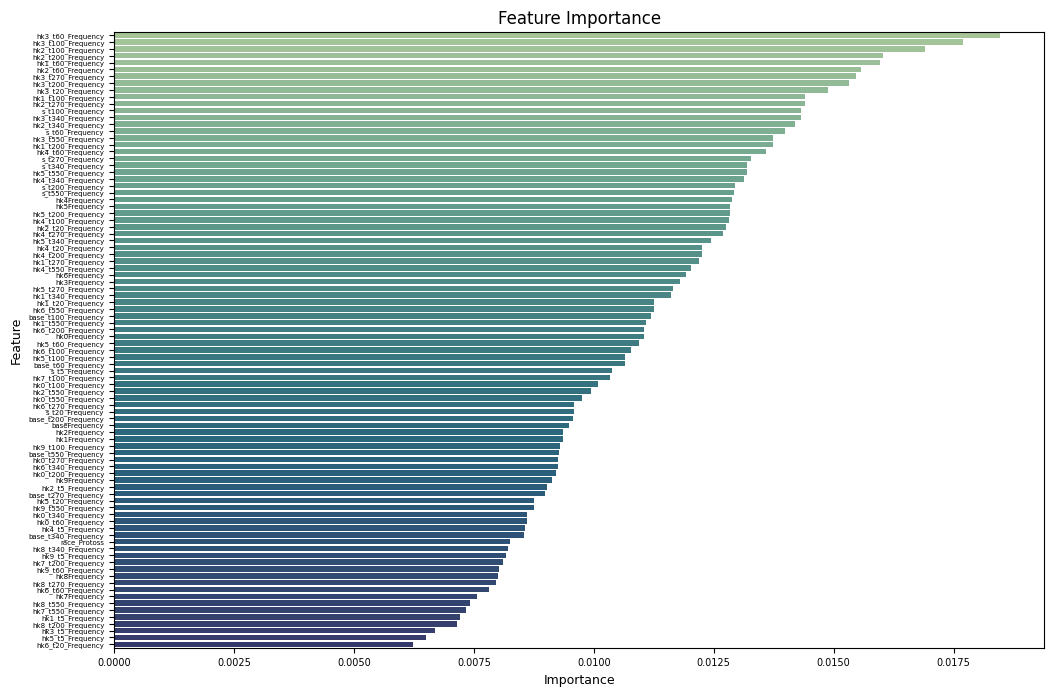

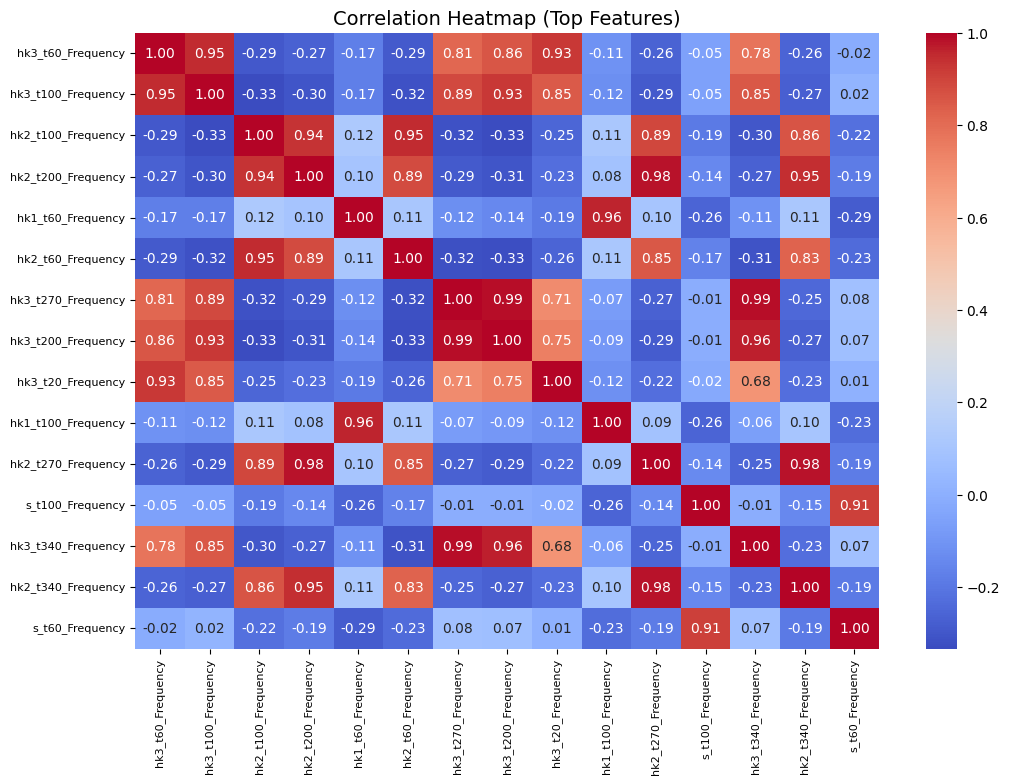

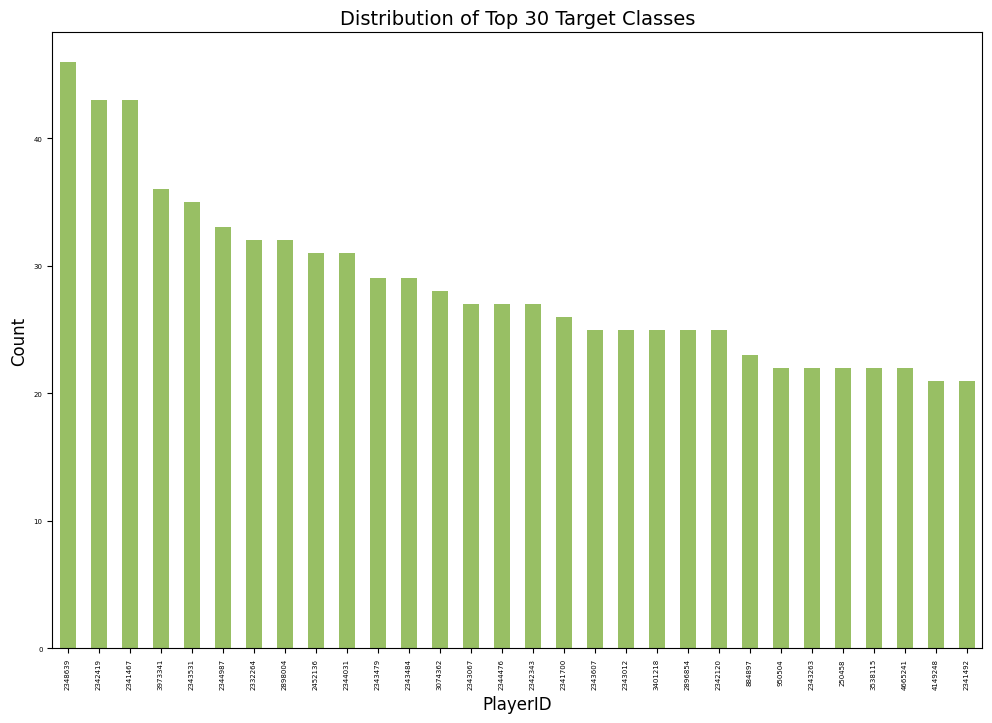

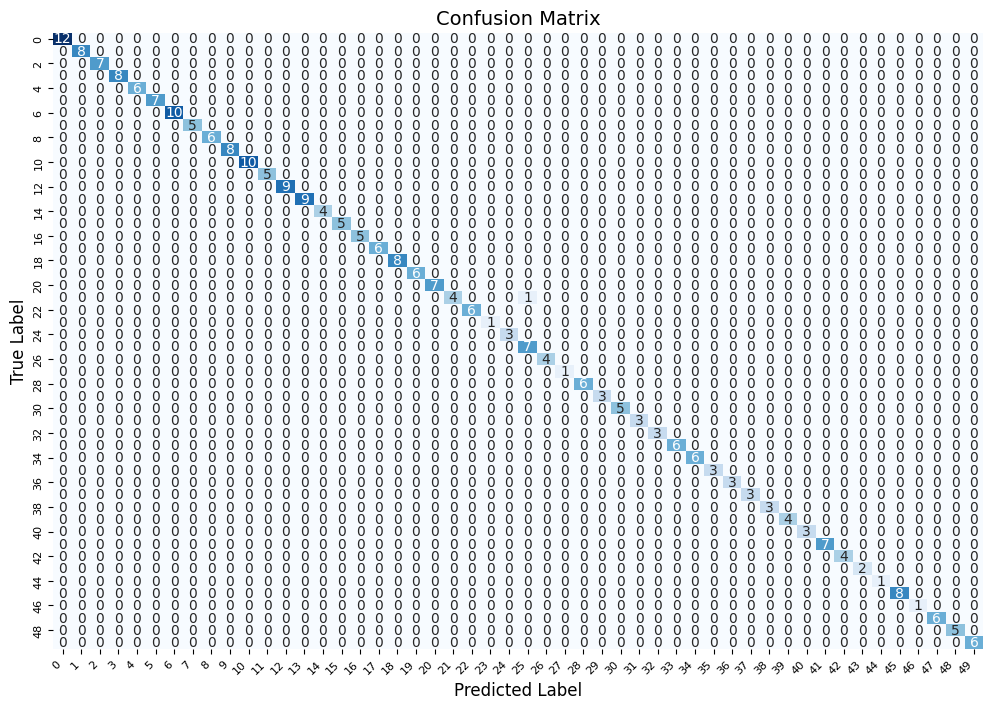

In [8]:

# Feature Importance
feature_importances_df = pd.DataFrame({'Feature': X_train_selected.columns, 'Importance': boosting_model.feature_importances_})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette="crest")
plt.title("Feature Importance", fontsize=12)
plt.xticks(fontsize=7)
plt.yticks(fontsize=5)
plt.xlabel("Importance", fontsize=9)
plt.ylabel("Feature", fontsize=9)
plt.show()

# Displaying the top correlated features
top_features = feature_importances_df.nlargest(15, 'Importance')['Feature']
correlation_matrix = pd.DataFrame(X_train_selected[top_features]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Top Features)", fontsize=14)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Target Classes Distribution
top_classes = y_train.value_counts().nlargest(30)
plt.figure(figsize=(12, 8))
top_classes.plot(kind='bar', color="#98BF64")
plt.title("Distribution of Top 30 Target Classes", fontsize=14)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.xlabel("PlayerID", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Confusion Matrix (after model prediction)
top_classes_cm = y_train.value_counts().nlargest(50)

conf_matrix = confusion_matrix(y_val, predictions, labels=top_classes_cm.index)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8)
plt.show()